In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile
import shutil
from PIL import Image
from imgaug import augmenters as iaa
import numpy as np
import pandas as pd
import time
import dask.bag as db
import dask.diagnostics as dd
import random
from termcolor import colored
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2M, EfficientNetV2B0, EfficientNetV2B3, Xception, ResNet50
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Precision, Recall, F1Score

2024-11-05 01:48:13.703729: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-05 01:48:13.703785: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-05 01:48:13.703836: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-05 01:48:13.713851: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
CWD = os.getcwd()
CWD

'/workspace/Brain-Tumor-Classification'

In [3]:
EPOCHS = 40
SAVE_DIRECTORY = CWD + '/model'

# Load Data

In [4]:
BASE_DIR = os.path.join(CWD, 'dataset', 'processed', 'Training')
TEST_DIR = os.path.join(CWD, 'dataset', 'processed', 'Testing')

In [5]:
# Loop over folders to extract class_names
classes = [class_name for class_name in os.listdir(BASE_DIR)]
classes

['glioma', 'meningioma', 'notumor', 'pituitary']

In [6]:
def prepare_dataset(BASE_DIR, IMG_SIZE, batch_size):
    train_full = tf.keras.utils.image_dataset_from_directory(
        directory=BASE_DIR,        
        labels='inferred',         
        label_mode='categorical',  
        class_names=classes,       
        seed=42,                   
        batch_size=batch_size,             
        image_size=(IMG_SIZE, IMG_SIZE)      
    )

    train_full = train_full.prefetch(tf.data.AUTOTUNE)
    
    # Counting number of all batches in dataset
    num_of_full_train_batches = len(list(train_full))
    print(colored(f'Number of batches in train_full : {num_of_full_train_batches}', 'black', attrs=['bold']))
    
    # Define variable to store number of batches for train dataset
    num_train_batches = int(num_of_full_train_batches * 0.70)
    
    # Define variable to store number of batches for validation and test dataset
    num_valid_test_batches = num_of_full_train_batches - num_train_batches
    
    # Print the TARGET : number of batches for train, validation and test dataset to each
    print(colored(' Target : ', 'green', attrs=['bold']))
    print('-'*35)
    print(colored(f'Number of  Train  batches : {num_train_batches}', 'blue', attrs=['bold']))
    print(colored(f'Number of Validation batches : {num_valid_test_batches//2}', 'blue', attrs=['bold']))
    print(colored(f'Number of Test batches : {num_valid_test_batches//2}', 'blue', attrs=['bold']))

    # Apply above settings to main dataset to split to train, validation and test dataset
    train_ds = train_full.take(num_train_batches)
    remain_ds = train_full.skip(num_train_batches)
    valid_ds = remain_ds.take(num_valid_test_batches)

    train_ds = train_ds.shuffle(buffer_size=3)
    

    test_ds = tf.keras.utils.image_dataset_from_directory(
        directory=TEST_DIR,
        labels='inferred',
        label_mode = 'categorical',
        class_names=classes,
        seed=42,
        batch_size=batch_size,
        image_size=(IMG_SIZE, IMG_SIZE)
    )

    return train_ds, valid_ds, test_ds

In [7]:
def build_model_trainable_last25(base_model, input_shape, num_classes):
    input = tf.keras.layers.Input(shape=input_shape)
    
    base_model = base_model(input_shape=input_shape, include_top=False, classes=num_classes, weights='imagenet')
    base_model.trainable = True

    # Freeze first 75% layers
    total_layers = len(base_model.layers)
    for layer in base_model.layers[:(int(0.75 * total_layers))]:
        layer.trainable = False

    x = base_model(input, training=False)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)               
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    output = tf.keras.layers.Dense(4, activation='softmax')(x)

    model = tf.keras.Model(inputs=input, outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy', F1Score()]
    )

    return model    

In [8]:
def build_model_trainable_first25(base_model, input_shape, num_classes):
    input = tf.keras.layers.Input(shape=input_shape)
    
    base_model = base_model(input_shape=input_shape, include_top=False, classes=num_classes, weights='imagenet')
    base_model.trainable = True

    # Freeze last 75% layers
    total_layers = len(base_model.layers)
    for layer in base_model.layers[(int(0.75 * total_layers)):]:
        layer.trainable = False

    x = base_model(input, training=False)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)               
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    output = tf.keras.layers.Dense(4, activation='softmax')(x)

    model = tf.keras.Model(inputs=input, outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy', F1Score()]
    )

    return model  

In [9]:
def build_model_not_trainable(base_model, input_shape, num_classes):
    input = tf.keras.layers.Input(shape=input_shape)
    
    base_model = base_model(input_shape=input_shape, include_top=False, classes=num_classes, weights='imagenet')
    base_model.trainable = False

    x = base_model(input, training=False)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)               
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    output = tf.keras.layers.Dense(4, activation='softmax')(x)

    model = tf.keras.Model(inputs=input, outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy', F1Score()]
    )

    return model

In [10]:
def train(model, model_name, train_ds, valid_ds, epochs, save_directory):
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)

    saving_path = os.path.join(save_directory, f'model_{model_name}.h5')

    # Model CheckPoint Call-Back, to save best model parameters as a .keras file
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(saving_path, monitor='val_accuracy', save_best_only=True)

    # Early Stoping Call-Backc to stop trainig process after 'patience' epochs if the metric doesn't grow
    earlystop_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

    # ReduceLROnPlateau Call-Back to decrease learning-rate base on 'monitor' parameter after 'patience' epochs with a 'factor' is doesn't improve
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

    start = time.time()

    # Model training
    history = model.fit(
        train_ds,
        epochs=epochs,
        validation_data = valid_ds,
        callbacks=[checkpoint_cb, earlystop_cb, reduce_lr]
    )

    end = time.time()

    # Counting trianing time
    training_time = end - start
    print(f"Training completed in {training_time:.2f} seconds.")

    return model, history, training_time

In [11]:
def best_variant(model_name_1, model_1, history_1, time_1,
                 model_name_2, model_2, history_2, time_2,
                 model_name_3, model_3, history_3, time_3,
                 test_ds, result_dict):

    # Extract validation F1 scores (assuming validation accuracy as a proxy)
    val_f1score_1 = history_1.history['val_accuracy']
    val_f1score_2 = history_2.history['val_accuracy']
    val_f1score_3 = history_3.history['val_accuracy']

    # Determine the best model based on validation F1 score
    if val_f1score_1 >= val_f1score_2 and val_f1score_1 >= val_f1score_3:
        best_model = model_1
        best_history = history_1
        best_model_name = model_name_1
        best_time = time_1
    elif val_f1score_2 >= val_f1score_1 and val_f1score_2 >= val_f1score_3:
        best_model = model_2
        best_history = history_2
        best_model_name = model_name_2
        best_time = time_2
    else:
        best_model = model_3
        best_history = history_3
        best_model_name = model_name_3
        best_time = time_3

    # Plot training history of the best model
    best_history, test_loss, test_acc, test_f1score = plot(best_model, best_history, test_ds)

    # Add the best result to result dictionary
    result(best_model_name, test_loss, test_acc, test_f1score, result_dict, best_time)

    print(f"Best model: {best_model_name}")
    print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

    return best_history, test_loss, test_acc, result_dict
    

In [12]:
def plot(model, history, test_ds):
    # Convert result of training to DataFrame
    result = pd.DataFrame(history.history)

    # Define a X variable to store range of epochs
    x = np.arange(len(result))

    # Create a plot with 3 row and 1 col with size of (15, 12)
    fig, ax = plt.subplots(2, 1, figsize=(15, 12))

    # AX0 : Loss
    ax[0].plot(x, result.loss, label='loss', linewidth=3)
    ax[0].plot(x, result.val_loss, label='val_loss', linewidth=2)
    ax[0].set_title('Loss', fontsize=20)
    ax[0].set_xticks(np.arange(0, len(x), 2))
    ax[0].legend()

    #  AX1 : Loss
    ax[1].plot(x, result.accuracy, label='accuracy', linewidth=2)
    ax[1].plot(x, result.val_accuracy, label='val_accuracy', linewidth=2)
    ax[1].set_title('Accuracy', fontsize=20)
    ax[1].set_xticks(np.arange(0, len(x), 2))
    ax[1].legend()


    # Evaluate model
    test_loss, test_acc, test_f1score = model.evaluate(test_ds, verbose=1)


    # Confusion Matrix
    # Get the class names from the dataset
    class_names = sorted(classes)

    # Make predictions
    y_pred = []
    y_true = []

    for images, labels in test_ds:
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))

        # If labels are one-hot encoded, convert to class indices
        if len(labels.shape) > 1:
            labels = np.argmax(labels, axis=1)
        y_true.extend(labels)

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    
    plt.show()

    print('Classification Report')
    cr = classification_report(y_true, y_pred, digits=5)
    print(cr)

    return history, test_loss, test_acc, test_f1score


In [13]:
def val_result(model_name, val_loss, val_acc, val_f1score, result_dict, training_time):
    result_dict['Model Name'].append(model_name)
    result_dict['Test Loss'].append(test_loss)
    result_dict['Test Accuracy'].append(test_acc)
    result_dict['Test F1Score'].append(test_f1score[0])
    result_dict['Training Time'].append(training_time)

result_dict = {
    'Model Name': [],
    'Validation Loss': [],
    'Validation Accuracy': [],
    'Validation F1Score': [],
    'Training Time': []
}

In [14]:
def result(model_name, test_loss, test_acc, test_f1score, result_dict, training_time):
    result_dict['Model Name'].append(model_name)
    result_dict['Test Loss'].append(test_loss)
    result_dict['Test Accuracy'].append(test_acc)
    result_dict['Test F1Score'].append(test_f1score[0])
    result_dict['Training Time'].append(training_time)

result_dict = {
    'Model Name': [],
    'Test Loss': [],
    'Test Accuracy': [],
    'Test F1Score': [],
    'Training Time': []
}

# Prepare training dataset

In [15]:
train_ds_224, valid_ds_224, test_ds_224 = prepare_dataset(BASE_DIR, 224, 32)
train_ds_300, valid_ds_300, test_ds_300 = prepare_dataset(BASE_DIR, 300, 24)
train_ds_380, valid_ds_380, test_ds_380 = prepare_dataset(BASE_DIR, 380, 8)

Found 5712 files belonging to 4 classes.


2024-11-05 01:48:35.039869: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22289 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:a1:00.0, compute capability: 8.9
2024-11-05 01:48:35.988219: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Number of batches in train_full : 179
 Target : 
-----------------------------------
Number of  Train  batches : 125
Number of Validation batches : 27
Number of Test batches : 27
Found 1311 files belonging to 4 classes.
Found 5712 files belonging to 4 classes.
Number of batches in train_full : 238
 Target : 
-----------------------------------
Number of  Train  batches : 166
Number of Validation batches : 36
Number of Test batches : 36
Found 1311 files belonging to 4 classes.
Found 5712 files belonging to 4 classes.
Number of batches in train_full : 714
 Target : 
-----------------------------------
Number of  Train  batches : 499
Number of Validation batches : 107
Number of Test batches : 107
Found 1311 files belonging to 4 classes.


# Model Training

## Standard

### EfficientNetV2B0

#### trainable first25

In [49]:
model_name_1 = 'EfficientnetV2B0 Standard Trainable First 25 Layer'
input_shape = (224,224,3)

std_b0_tf25 = build_model_trainable_first25(EfficientNetV2B0, input_shape=input_shape, num_classes=4)
std_b0_tf25, history_std_b0_tf25, training_time_1 = train(std_b0_tf25, model_name_1, train_ds_224, valid_ds_224, EPOCHS, SAVE_DIRECTORY)

Epoch 1/40


2024-11-04 12:43:38.706925: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/dropout_14/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


125/125 [==============================] - 36s 97ms/step - loss: 0.6658 - accuracy: 0.7452 - f1_score: 0.7416 - val_loss: 0.2582 - val_accuracy: 0.9071 - val_f1_score: 0.9005 - lr: 1.0000e-04
Epoch 2/40
125/125 [==============================] - 10s 83ms/step - loss: 0.2764 - accuracy: 0.9050 - f1_score: 0.9021 - val_loss: 0.1731 - val_accuracy: 0.9410 - val_f1_score: 0.9386 - lr: 1.0000e-04
Epoch 3/40
125/125 [==============================] - 11s 84ms/step - loss: 0.1444 - accuracy: 0.9517 - f1_score: 0.9506 - val_loss: 0.0940 - val_accuracy: 0.9696 - val_f1_score: 0.9682 - lr: 1.0000e-04
Epoch 4/40
125/125 [==============================] - 11s 86ms/step - loss: 0.0707 - accuracy: 0.9790 - f1_score: 0.9785 - val_loss: 0.0776 - val_accuracy: 0.9749 - val_f1_score: 0.9739 - lr: 1.0000e-04
Epoch 5/40
125/125 [==============================] - 11s 86ms/step - loss: 0.0670 - accuracy: 0.9770 - f1_score: 0.9763 - val_loss: 0.0667 - val_accuracy: 0.9796 - val_f1_score: 0.9784 - lr: 1.0000e

#### trainable last25

In [50]:
model_name_2 = 'EfficientnetV2B0 Standard Trainable Last 25 Layer'
input_shape = (224,224,3)

std_b0_tl25 = build_model_trainable_last25(EfficientNetV2B0, input_shape=input_shape, num_classes=4)
std_b0_tl25, history_std_b0_tl25, training_time_2 = train(std_b0_tl25, model_name_2, train_ds_224, valid_ds_224, EPOCHS, SAVE_DIRECTORY)

Epoch 1/40


2024-11-04 12:47:20.436037: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_8/dropout_16/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


125/125 [==============================] - 19s 66ms/step - loss: 0.6534 - accuracy: 0.7415 - f1_score: 0.7335 - val_loss: 0.3002 - val_accuracy: 0.8914 - val_f1_score: 0.8839 - lr: 1.0000e-04
Epoch 2/40
125/125 [==============================] - 7s 56ms/step - loss: 0.2565 - accuracy: 0.9110 - f1_score: 0.9086 - val_loss: 0.1813 - val_accuracy: 0.9369 - val_f1_score: 0.9310 - lr: 1.0000e-04
Epoch 3/40
125/125 [==============================] - 7s 54ms/step - loss: 0.1371 - accuracy: 0.9525 - f1_score: 0.9511 - val_loss: 0.1518 - val_accuracy: 0.9468 - val_f1_score: 0.9441 - lr: 1.0000e-04
Epoch 4/40
125/125 [==============================] - 7s 54ms/step - loss: 0.0790 - accuracy: 0.9703 - f1_score: 0.9693 - val_loss: 0.1101 - val_accuracy: 0.9714 - val_f1_score: 0.9698 - lr: 1.0000e-04
Epoch 5/40
125/125 [==============================] - 6s 47ms/step - loss: 0.0376 - accuracy: 0.9885 - f1_score: 0.9881 - val_loss: 0.1445 - val_accuracy: 0.9696 - val_f1_score: 0.9679 - lr: 1.0000e-04


#### not trainable

In [51]:
model_name_3 = 'EfficientnetV2B0 Standard Not Trainable'
input_shape = (224,224,3)

std_b0_nt = build_model_not_trainable(EfficientNetV2B0, input_shape=input_shape, num_classes=4)
std_b0_nt, history_std_b0_nt, training_time_3 = train(std_b0_nt, model_name_3, train_ds_224, valid_ds_224, EPOCHS, SAVE_DIRECTORY)

Epoch 1/40
125/125 [==============================] - 12s 50ms/step - loss: 0.9761 - accuracy: 0.6010 - f1_score: 0.5872 - val_loss: 0.5700 - val_accuracy: 0.8102 - val_f1_score: 0.7922 - lr: 1.0000e-04
Epoch 2/40
125/125 [==============================] - 5s 36ms/step - loss: 0.5563 - accuracy: 0.8015 - f1_score: 0.7931 - val_loss: 0.3915 - val_accuracy: 0.8662 - val_f1_score: 0.8593 - lr: 1.0000e-04
Epoch 3/40
125/125 [==============================] - 4s 33ms/step - loss: 0.4378 - accuracy: 0.8407 - f1_score: 0.8346 - val_loss: 0.3304 - val_accuracy: 0.8785 - val_f1_score: 0.8694 - lr: 1.0000e-04
Epoch 4/40
125/125 [==============================] - 4s 34ms/step - loss: 0.3814 - accuracy: 0.8640 - f1_score: 0.8591 - val_loss: 0.2963 - val_accuracy: 0.8902 - val_f1_score: 0.8831 - lr: 1.0000e-04
Epoch 5/40
125/125 [==============================] - 5s 43ms/step - loss: 0.3463 - accuracy: 0.8715 - f1_score: 0.8674 - val_loss: 0.2799 - val_accuracy: 0.8978 - val_f1_score: 0.8917 - lr: 

1/1 [==============================] - 1s 1s/step


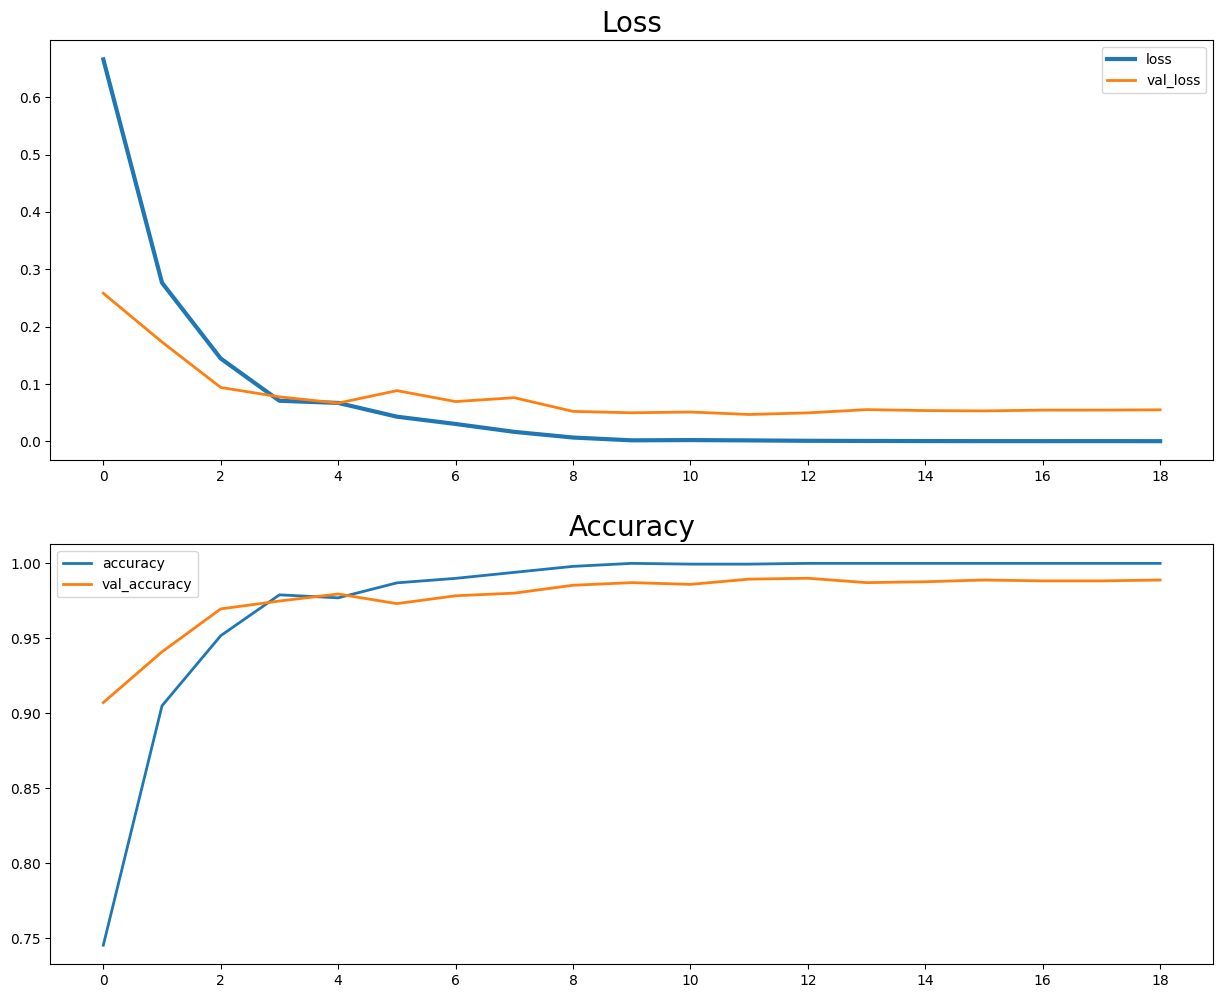

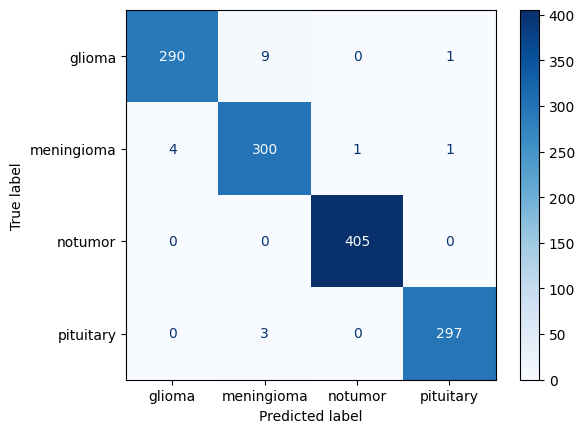

Classification Report
              precision    recall  f1-score   support

           0    0.98639   0.96667   0.97643       300
           1    0.96154   0.98039   0.97087       306
           2    0.99754   1.00000   0.99877       405
           3    0.99331   0.99000   0.99165       300

    accuracy                        0.98551      1311
   macro avg    0.98470   0.98426   0.98443      1311
weighted avg    0.98562   0.98551   0.98552      1311

Best model: EfficientnetV2B0 Standard Trainable First 25 Layer
Test Loss: 0.07815388590097427, Test Accuracy: 0.9855072498321533


(<keras.src.callbacks.History at 0x7f88ec222bd0>,
 0.07815388590097427,
 0.9855072498321533,
 {'Model Name': ['EfficientnetV2B0 Standard Trainable First 25 Layer'],
  'Test Loss': [0.07815388590097427],
  'Test Accuracy': [0.9855072498321533],
  'Test F1Score': [0.976431],
  'Training Time': [223.0917501449585]})

In [52]:
best_variant(model_name_1, std_b0_tf25, history_std_b0_tf25, training_time_1,
             model_name_2, std_b0_tl25, history_std_b0_tl25, training_time_2,
             model_name_3, std_b0_nt, history_std_b0_nt, training_time_3,
             test_ds_224, result_dict)

### EfficientNetV2B3

#### trainable first25

In [53]:
model_name_1 = 'EfficientnetV2B3 Standard Trainable First 25% Layer'
input_shape = (300,300,3)

std_b3_tf25 = build_model_trainable_first25(EfficientNetV2B3, input_shape=input_shape, num_classes=4)
std_b3_tf25, history_std_b3_tf25, training_time_1 = train(std_b3_tf25, model_name_1, train_ds_300, valid_ds_300, EPOCHS, SAVE_DIRECTORY)

Epoch 1/40


2024-11-04 12:52:25.209451: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_10/dropout_20/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


166/166 [==============================] - ETA: 0s - loss: 0.5614 - accuracy: 0.7836 - f1_score: 0.7792

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


166/166 [==============================] - 60s 146ms/step - loss: 0.5614 - accuracy: 0.7836 - f1_score: 0.7792 - val_loss: 0.1774 - val_accuracy: 0.9340 - val_f1_score: 0.9308 - lr: 1.0000e-04
Epoch 2/40
166/166 [==============================] - 22s 135ms/step - loss: 0.1547 - accuracy: 0.9465 - f1_score: 0.9452 - val_loss: 0.1216 - val_accuracy: 0.9595 - val_f1_score: 0.9579 - lr: 1.0000e-04
Epoch 3/40
166/166 [==============================] - 23s 139ms/step - loss: 0.0947 - accuracy: 0.9716 - f1_score: 0.9711 - val_loss: 0.0988 - val_accuracy: 0.9647 - val_f1_score: 0.9634 - lr: 1.0000e-04
Epoch 4/40
166/166 [==============================] - 19s 114ms/step - loss: 0.0437 - accuracy: 0.9869 - f1_score: 0.9867 - val_loss: 0.3140 - val_accuracy: 0.9126 - val_f1_score: 0.9025 - lr: 1.0000e-04
Epoch 5/40
166/166 [==============================] - 21s 129ms/step - loss: 0.0708 - accuracy: 0.9772 - f1_score: 0.9766 - val_loss: 0.0610 - val_accuracy: 0.9821 - val_f1_score: 0.9812 - lr: 1.

#### trainable last25

In [54]:
model_name_2 = 'EfficientnetV2B3 Standard Trainable Last 25% Layer'
input_shape = (300,300,3)

std_b3_tl25 = build_model_trainable_last25(EfficientNetV2B3, input_shape=input_shape, num_classes=4)
std_b3_tl25, history_std_b3_tl25, training_time_2 = train(std_b3_tl25, model_name_2, train_ds_300, valid_ds_300, EPOCHS, SAVE_DIRECTORY)

Epoch 1/40


2024-11-04 12:58:42.150842: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_11/dropout_22/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


166/166 [==============================] - 29s 78ms/step - loss: 0.5114 - accuracy: 0.8050 - f1_score: 0.8002 - val_loss: 0.2334 - val_accuracy: 0.9172 - val_f1_score: 0.9111 - lr: 1.0000e-04
Epoch 2/40
166/166 [==============================] - 11s 65ms/step - loss: 0.1604 - accuracy: 0.9428 - f1_score: 0.9413 - val_loss: 0.1172 - val_accuracy: 0.9595 - val_f1_score: 0.9566 - lr: 1.0000e-04
Epoch 3/40
166/166 [==============================] - 11s 68ms/step - loss: 0.0803 - accuracy: 0.9721 - f1_score: 0.9712 - val_loss: 0.1276 - val_accuracy: 0.9711 - val_f1_score: 0.9692 - lr: 1.0000e-04
Epoch 4/40
166/166 [==============================] - 14s 85ms/step - loss: 0.0427 - accuracy: 0.9869 - f1_score: 0.9864 - val_loss: 0.1056 - val_accuracy: 0.9792 - val_f1_score: 0.9777 - lr: 1.0000e-04
Epoch 5/40
166/166 [==============================] - 11s 68ms/step - loss: 0.0429 - accuracy: 0.9837 - f1_score: 0.9832 - val_loss: 0.2293 - val_accuracy: 0.9514 - val_f1_score: 0.9479 - lr: 1.0000e

#### not trainable

In [55]:
model_name_3 = 'EfficientnetV2B3 Standard Not Trainable'
input_shape = (300,300,3)

std_b3_nt = build_model_not_trainable(EfficientNetV2B3, input_shape=input_shape, num_classes=4)
std_b3_nt, history_std_b3_nt, training_time_3 = train(std_b3_nt, model_name_3, train_ds_300, valid_ds_300, EPOCHS, SAVE_DIRECTORY)

Epoch 1/40
166/166 [==============================] - 18s 65ms/step - loss: 0.8866 - accuracy: 0.6463 - f1_score: 0.6352 - val_loss: 0.4925 - val_accuracy: 0.8067 - val_f1_score: 0.7817 - lr: 1.0000e-04
Epoch 2/40
166/166 [==============================] - 8s 48ms/step - loss: 0.5079 - accuracy: 0.8022 - f1_score: 0.7934 - val_loss: 0.3611 - val_accuracy: 0.8721 - val_f1_score: 0.8589 - lr: 1.0000e-04
Epoch 3/40
166/166 [==============================] - 8s 47ms/step - loss: 0.4114 - accuracy: 0.8499 - f1_score: 0.8446 - val_loss: 0.3072 - val_accuracy: 0.8900 - val_f1_score: 0.8811 - lr: 1.0000e-04
Epoch 4/40
166/166 [==============================] - 9s 51ms/step - loss: 0.3529 - accuracy: 0.8675 - f1_score: 0.8634 - val_loss: 0.2714 - val_accuracy: 0.8999 - val_f1_score: 0.8910 - lr: 1.0000e-04
Epoch 5/40
166/166 [==============================] - 8s 45ms/step - loss: 0.3232 - accuracy: 0.8855 - f1_score: 0.8819 - val_loss: 0.2496 - val_accuracy: 0.9086 - val_f1_score: 0.9008 - lr: 

1/1 [==============================] - 0s 39ms/step


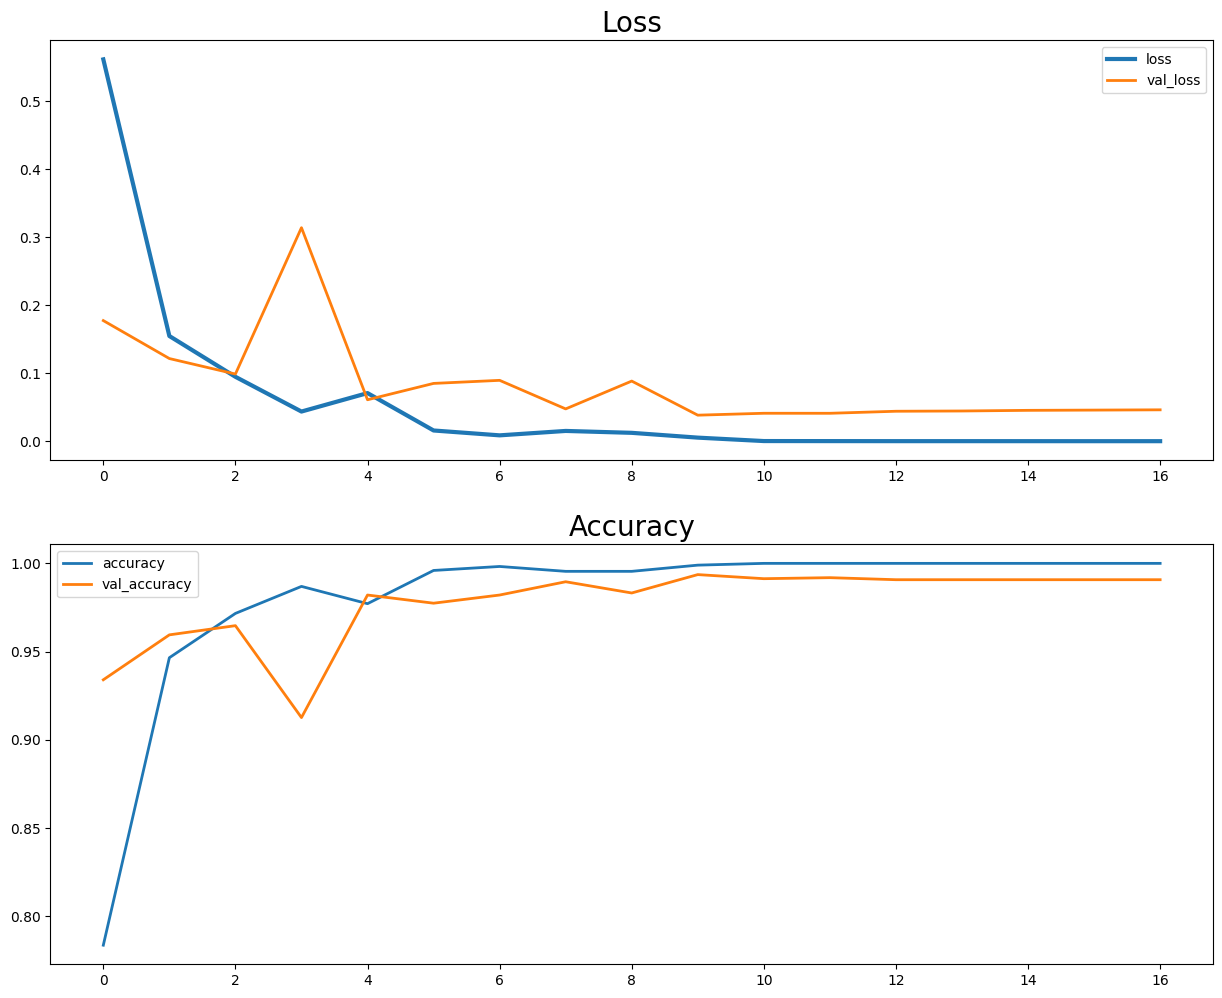

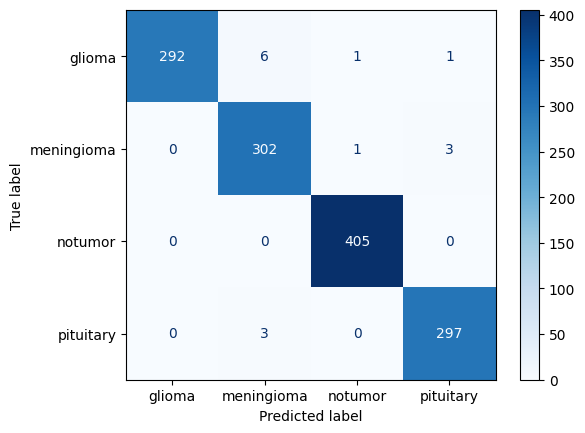

Classification Report
              precision    recall  f1-score   support

           0    1.00000   0.97333   0.98649       300
           1    0.97106   0.98693   0.97893       306
           2    0.99509   1.00000   0.99754       405
           3    0.98671   0.99000   0.98835       300

    accuracy                        0.98856      1311
   macro avg    0.98821   0.98757   0.98783      1311
weighted avg    0.98869   0.98856   0.98856      1311

Best model: EfficientnetV2B3 Standard Trainable First 25 Layer
Test Loss: 0.067006915807724, Test Accuracy: 0.9885583519935608


(<keras.src.callbacks.History at 0x7f8a33672bd0>,
 0.067006915807724,
 0.9885583519935608,
 {'Model Name': ['EfficientnetV2B0 Standard Trainable First 25 Layer',
   'EfficientnetV2B3 Standard Trainable First 25 Layer'],
  'Test Loss': [0.07815388590097427, 0.067006915807724],
  'Test Accuracy': [0.9855072498321533, 0.9885583519935608],
  'Test F1Score': [0.976431, 0.9864865],
  'Training Time': [223.0917501449585, 381.1360716819763]})

In [56]:
best_variant(model_name_1, std_b3_tf25, history_std_b3_tf25, training_time_1,
             model_name_2, std_b3_tl25, history_std_b3_tl25, training_time_2,
             model_name_3, std_b3_nt, history_std_b3_nt, training_time_3,
             test_ds_300, result_dict)

### EfficientNetV2M

#### trainable first25

In [57]:
model_name_1 = 'EfficientnetV2M Standard Trainable First 25 Layer'
input_shape = (380,380,3)

std_m_tf25 = build_model_trainable_first25(EfficientNetV2M, input_shape=input_shape, num_classes=4)
std_m_tf25, history_std_m_tf25, training_time_1 = train(std_m_tf25, model_name_1, train_ds_380, valid_ds_380, EPOCHS, SAVE_DIRECTORY)

214201816/214201816 [==============================] - 6s 0us/step
Epoch 1/40


2024-11-04 13:08:22.299404: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_13/dropout_26/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


499/499 [==============================] - ETA: 0s - loss: 0.5677 - accuracy: 0.7971 - f1_score: 0.7933

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


499/499 [==============================] - 158s 173ms/step - loss: 0.5677 - accuracy: 0.7971 - f1_score: 0.7933 - val_loss: 0.2736 - val_accuracy: 0.9070 - val_f1_score: 0.8979 - lr: 1.0000e-04
Epoch 2/40
499/499 [==============================] - 82s 165ms/step - loss: 0.2115 - accuracy: 0.9359 - f1_score: 0.9345 - val_loss: 0.2319 - val_accuracy: 0.9291 - val_f1_score: 0.9263 - lr: 1.0000e-04
Epoch 3/40
499/499 [==============================] - 81s 163ms/step - loss: 0.0899 - accuracy: 0.9765 - f1_score: 0.9761 - val_loss: 0.1054 - val_accuracy: 0.9703 - val_f1_score: 0.9697 - lr: 1.0000e-04
Epoch 4/40
499/499 [==============================] - 78s 156ms/step - loss: 0.0837 - accuracy: 0.9755 - f1_score: 0.9749 - val_loss: 0.2269 - val_accuracy: 0.9279 - val_f1_score: 0.9267 - lr: 1.0000e-04
Epoch 5/40
499/499 [==============================] - 79s 158ms/step - loss: 0.0721 - accuracy: 0.9782 - f1_score: 0.9778 - val_loss: 0.1371 - val_accuracy: 0.9517 - val_f1_score: 0.9471 - lr: 1

#### trainable last25

In [58]:
model_name_2 = 'EfficientnetV2M Standard Trainable Last 25 Layer'
input_shape = (380,380,3)

std_m_tl25 = build_model_trainable_last25(EfficientNetV2M, input_shape=input_shape, num_classes=4)
std_m_tl25, history_std_m_tl25, training_time_2 = train(std_m_tl25, model_name_2, train_ds_380, valid_ds_380, EPOCHS, SAVE_DIRECTORY)

Epoch 1/40


2024-11-04 13:29:28.431226: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_14/dropout_28/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


499/499 [==============================] - 87s 113ms/step - loss: 0.4430 - accuracy: 0.8369 - f1_score: 0.8319 - val_loss: 0.2042 - val_accuracy: 0.9273 - val_f1_score: 0.9218 - lr: 1.0000e-04
Epoch 2/40
499/499 [==============================] - 50s 100ms/step - loss: 0.1648 - accuracy: 0.9471 - f1_score: 0.9457 - val_loss: 0.1079 - val_accuracy: 0.9686 - val_f1_score: 0.9666 - lr: 1.0000e-04
Epoch 3/40
499/499 [==============================] - 51s 103ms/step - loss: 0.0841 - accuracy: 0.9765 - f1_score: 0.9758 - val_loss: 0.1010 - val_accuracy: 0.9698 - val_f1_score: 0.9681 - lr: 1.0000e-04
Epoch 4/40
499/499 [==============================] - 47s 95ms/step - loss: 0.0587 - accuracy: 0.9827 - f1_score: 0.9823 - val_loss: 0.1251 - val_accuracy: 0.9663 - val_f1_score: 0.9649 - lr: 1.0000e-04
Epoch 5/40
499/499 [==============================] - 47s 94ms/step - loss: 0.0648 - accuracy: 0.9820 - f1_score: 0.9816 - val_loss: 0.1330 - val_accuracy: 0.9634 - val_f1_score: 0.9605 - lr: 1.00

#### not trainable

In [59]:
model_name_3 = 'EfficientnetV2M Standard Not Trainable'
input_shape = (380,380,3)

std_m_nt = build_model_not_trainable(EfficientNetV2M, input_shape=input_shape, num_classes=4)
std_m_nt, history_std_m_nt, training_time_3 = train(std_m_nt, model_name_3, train_ds_380, valid_ds_380, EPOCHS, SAVE_DIRECTORY)

Epoch 1/40
499/499 [==============================] - 48s 69ms/step - loss: 0.8034 - accuracy: 0.6743 - f1_score: 0.6648 - val_loss: 0.5012 - val_accuracy: 0.8047 - val_f1_score: 0.7877 - lr: 1.0000e-04
Epoch 2/40
499/499 [==============================] - 31s 62ms/step - loss: 0.4869 - accuracy: 0.8151 - f1_score: 0.8082 - val_loss: 0.4011 - val_accuracy: 0.8355 - val_f1_score: 0.8166 - lr: 1.0000e-04
Epoch 3/40
499/499 [==============================] - 31s 62ms/step - loss: 0.4143 - accuracy: 0.8407 - f1_score: 0.8352 - val_loss: 0.3326 - val_accuracy: 0.8686 - val_f1_score: 0.8564 - lr: 1.0000e-04
Epoch 4/40
499/499 [==============================] - 34s 67ms/step - loss: 0.3550 - accuracy: 0.8675 - f1_score: 0.8627 - val_loss: 0.3044 - val_accuracy: 0.8767 - val_f1_score: 0.8648 - lr: 1.0000e-04
Epoch 5/40
499/499 [==============================] - 31s 62ms/step - loss: 0.3214 - accuracy: 0.8775 - f1_score: 0.8736 - val_loss: 0.2725 - val_accuracy: 0.8942 - val_f1_score: 0.8861 - 

1/1 [==============================] - 0s 51ms/step


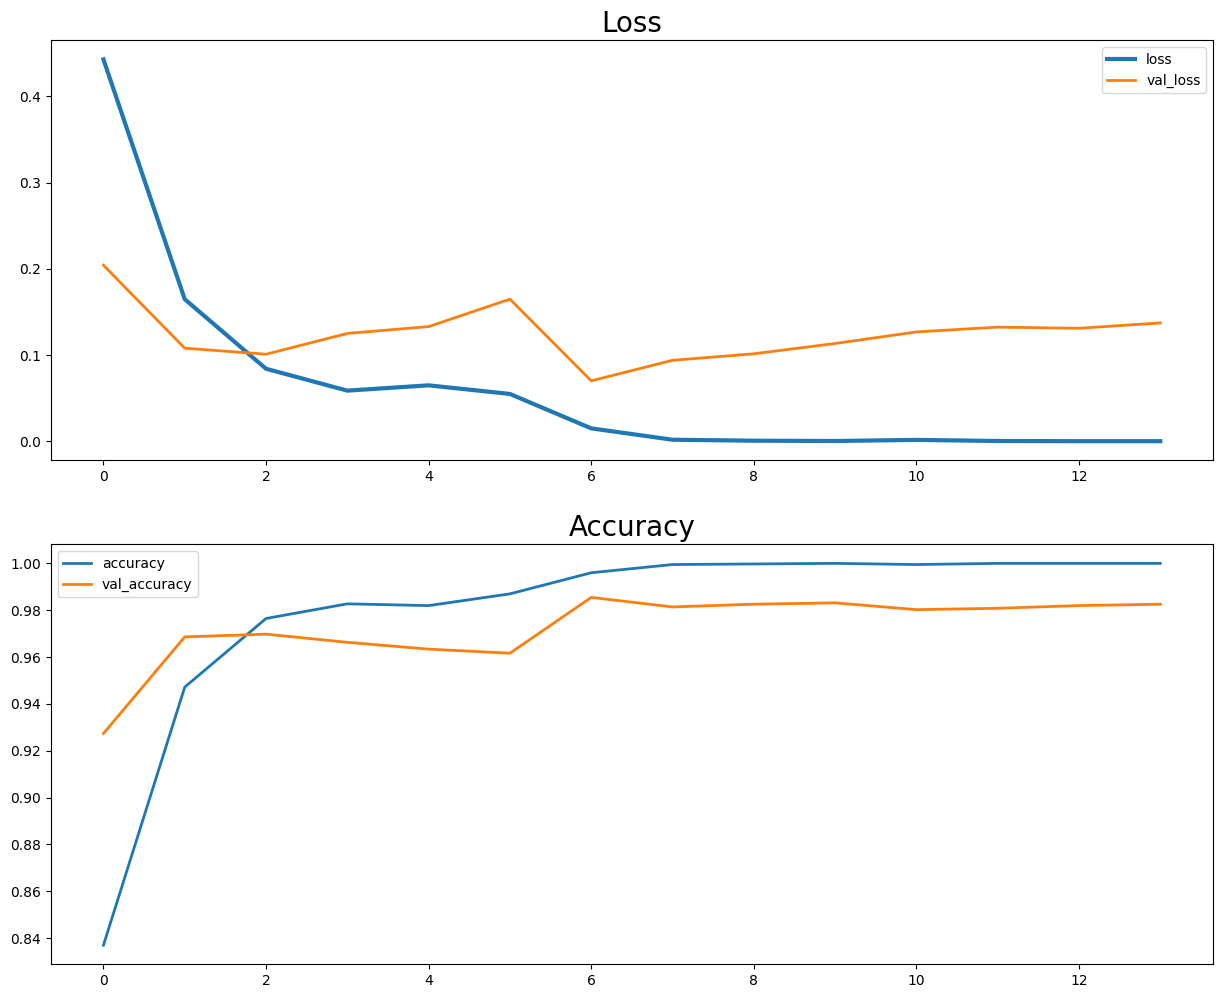

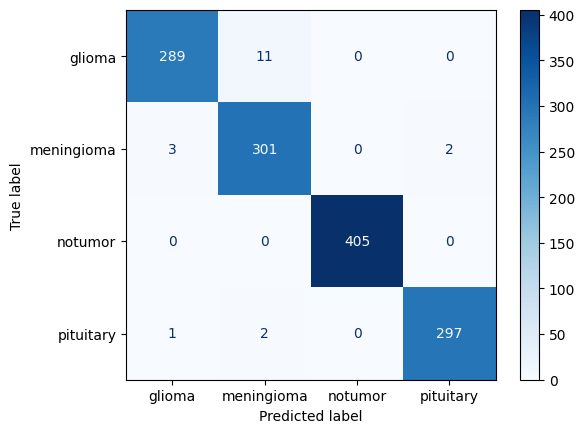

Classification Report
              precision    recall  f1-score   support

           0    0.98635   0.96333   0.97470       300
           1    0.95860   0.98366   0.97097       306
           2    1.00000   1.00000   1.00000       405
           3    0.99331   0.99000   0.99165       300

    accuracy                        0.98551      1311
   macro avg    0.98456   0.98425   0.98433      1311
weighted avg    0.98568   0.98551   0.98553      1311

Best model: EfficientnetV2M Standard Trainable Last 25 Layer
Test Loss: 0.05467250198125839, Test Accuracy: 0.9855072498321533


(<keras.src.callbacks.History at 0x7f896656c590>,
 0.05467250198125839,
 0.9855072498321533,
 {'Model Name': ['EfficientnetV2B0 Standard Trainable First 25 Layer',
   'EfficientnetV2B3 Standard Trainable First 25 Layer',
   'EfficientnetV2M Standard Trainable Last 25 Layer'],
  'Test Loss': [0.07815388590097427, 0.067006915807724, 0.05467250198125839],
  'Test Accuracy': [0.9855072498321533,
   0.9885583519935608,
   0.9855072498321533],
  'Test F1Score': [0.976431, 0.9864865, 0.97470486],
  'Training Time': [223.0917501449585, 381.1360716819763, 716.5882251262665]})

In [60]:
best_variant(model_name_1, std_m_tf25, history_std_m_tf25, training_time_1,
             model_name_2, std_m_tl25, history_std_m_tl25, training_time_2,
             model_name_3, std_m_nt, history_std_m_nt, training_time_3,
             test_ds_380, result_dict)

## Augmentation

In [16]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.25),
    tf.keras.layers.RandomTranslation(0.15, 0.15),
    # tf.keras.layers.RandomZoom(0.2, 0.2),
    # tf.keras.layers.RandomBrightness(0.2)
])

In [17]:
def augmentation_train(image, label):
    image = preprocess_input(image)
    image = data_augmentation(image)
    return image, label

def preprocess_val(image, label):
    image = preprocess_input(image)
    return image, label

In [18]:
train_aug_224 = train_ds_224.map(augmentation_train, num_parallel_calls=tf.data.AUTOTUNE)
valid_aug_224 = valid_ds_224.map(preprocess_val, num_parallel_calls=tf.data.AUTOTUNE)

train_aug_224 = train_aug_224.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_aug_224 = valid_aug_224.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
train_aug_300 = train_ds_300.map(augmentation_train, num_parallel_calls=tf.data.AUTOTUNE)
valid_aug_300 = valid_ds_300.map(preprocess_val, num_parallel_calls=tf.data.AUTOTUNE)

train_aug_300 = train_aug_300.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_aug_300 = valid_aug_300.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
train_aug_380 = train_ds_380.map(augmentation_train, num_parallel_calls=tf.data.AUTOTUNE)
valid_aug_380 = valid_ds_380.map(preprocess_val, num_parallel_calls=tf.data.AUTOTUNE)

train_aug_380 = train_aug_380.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_aug_380 = valid_aug_380.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
train_aug_224 = train_aug_224.concatenate(train_ds_224)
train_aug_300 = train_aug_300.concatenate(train_ds_300)
train_aug_380 = train_aug_380.concatenate(train_ds_380)

### EfficientNetV2B0

#### trainable first25

In [112]:
model_name_1 = 'EfficientnetV2B0 Augmentation Trainable First 25 Layer'
input_shape = (224,224,3)

aug_b0_tf25 = build_model_trainable_first25(EfficientNetV2B0, input_shape=input_shape, num_classes=4)
aug_b0_tf25, history_aug_b0_tf25, training_time_1 = train(aug_b0_tf25, model_name_1, train_aug_224, valid_aug_224, EPOCHS, SAVE_DIRECTORY)

Epoch 1/40


2024-11-04 15:08:44.116804: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_28/dropout_56/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


250/250 [==============================] - 48s 80ms/step - loss: 0.5420 - accuracy: 0.7871 - f1_score: 0.7828 - val_loss: 0.1486 - val_accuracy: 0.9457 - val_f1_score: 0.9430 - lr: 1.0000e-04
Epoch 2/40
250/250 [==============================] - 19s 76ms/step - loss: 0.1789 - accuracy: 0.9376 - f1_score: 0.9363 - val_loss: 0.0888 - val_accuracy: 0.9725 - val_f1_score: 0.9709 - lr: 1.0000e-04
Epoch 3/40
250/250 [==============================] - 18s 73ms/step - loss: 0.0820 - accuracy: 0.9719 - f1_score: 0.9714 - val_loss: 0.0653 - val_accuracy: 0.9801 - val_f1_score: 0.9792 - lr: 1.0000e-04
Epoch 4/40
250/250 [==============================] - 18s 71ms/step - loss: 0.0491 - accuracy: 0.9833 - f1_score: 0.9829 - val_loss: 0.0875 - val_accuracy: 0.9761 - val_f1_score: 0.9746 - lr: 1.0000e-04
Epoch 5/40
250/250 [==============================] - 18s 71ms/step - loss: 0.0443 - accuracy: 0.9865 - f1_score: 0.9862 - val_loss: 0.0844 - val_accuracy: 0.9778 - val_f1_score: 0.9774 - lr: 1.0000e

#### trainable last25

In [113]:
model_name_2 = 'EfficientnetV2B0 Augmentation Trainable Last 25 Layer'
input_shape = (224,224,3)

aug_b0_tl25 = build_model_trainable_last25(EfficientNetV2B0, input_shape=input_shape, num_classes=4)
aug_b0_tl25, history_aug_b0_tl25, training_time_2 = train(aug_b0_tl25, model_name_2, train_aug_224, valid_aug_224, EPOCHS, SAVE_DIRECTORY)

Epoch 1/40


2024-11-04 15:13:28.648880: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_29/dropout_58/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


250/250 [==============================] - 23s 47ms/step - loss: 0.5734 - accuracy: 0.7707 - f1_score: 0.7647 - val_loss: 0.2412 - val_accuracy: 0.9136 - val_f1_score: 0.9068 - lr: 1.0000e-04
Epoch 2/40
250/250 [==============================] - 10s 40ms/step - loss: 0.2230 - accuracy: 0.9208 - f1_score: 0.9187 - val_loss: 0.1216 - val_accuracy: 0.9591 - val_f1_score: 0.9569 - lr: 1.0000e-04
Epoch 3/40
250/250 [==============================] - 10s 39ms/step - loss: 0.1146 - accuracy: 0.9601 - f1_score: 0.9591 - val_loss: 0.1259 - val_accuracy: 0.9708 - val_f1_score: 0.9691 - lr: 1.0000e-04
Epoch 4/40
250/250 [==============================] - 10s 39ms/step - loss: 0.0675 - accuracy: 0.9783 - f1_score: 0.9776 - val_loss: 0.1551 - val_accuracy: 0.9655 - val_f1_score: 0.9639 - lr: 1.0000e-04
Epoch 5/40
250/250 [==============================] - 9s 38ms/step - loss: 0.0371 - accuracy: 0.9865 - f1_score: 0.9860 - val_loss: 0.1624 - val_accuracy: 0.9667 - val_f1_score: 0.9649 - lr: 1.0000e-

#### not trainable

In [114]:
model_name_3 = 'EfficientnetV2B0 Augmentation Not Trainable'
input_shape = (224,224,3)

aug_b0_nt = build_model_not_trainable(EfficientNetV2B0, input_shape=input_shape, num_classes=4)
aug_b0_nt, history_aug_b0_nt, training_time_3 = train(aug_b0_nt, model_name_3, train_aug_224, valid_aug_224, EPOCHS, SAVE_DIRECTORY)

Epoch 1/40
250/250 [==============================] - 13s 31ms/step - loss: 0.9118 - accuracy: 0.6260 - f1_score: 0.6182 - val_loss: 0.4284 - val_accuracy: 0.8551 - val_f1_score: 0.8430 - lr: 1.0000e-04
Epoch 2/40
250/250 [==============================] - 7s 26ms/step - loss: 0.5543 - accuracy: 0.7871 - f1_score: 0.7802 - val_loss: 0.3265 - val_accuracy: 0.8797 - val_f1_score: 0.8708 - lr: 1.0000e-04
Epoch 3/40
250/250 [==============================] - 7s 27ms/step - loss: 0.4529 - accuracy: 0.8254 - f1_score: 0.8195 - val_loss: 0.2837 - val_accuracy: 0.8949 - val_f1_score: 0.8868 - lr: 1.0000e-04
Epoch 4/40
250/250 [==============================] - 7s 27ms/step - loss: 0.4064 - accuracy: 0.8493 - f1_score: 0.8443 - val_loss: 0.2602 - val_accuracy: 0.9065 - val_f1_score: 0.8993 - lr: 1.0000e-04
Epoch 5/40
250/250 [==============================] - 7s 27ms/step - loss: 0.3761 - accuracy: 0.8595 - f1_score: 0.8556 - val_loss: 0.2444 - val_accuracy: 0.9095 - val_f1_score: 0.9037 - lr: 

1/1 [==============================] - 1s 1s/step


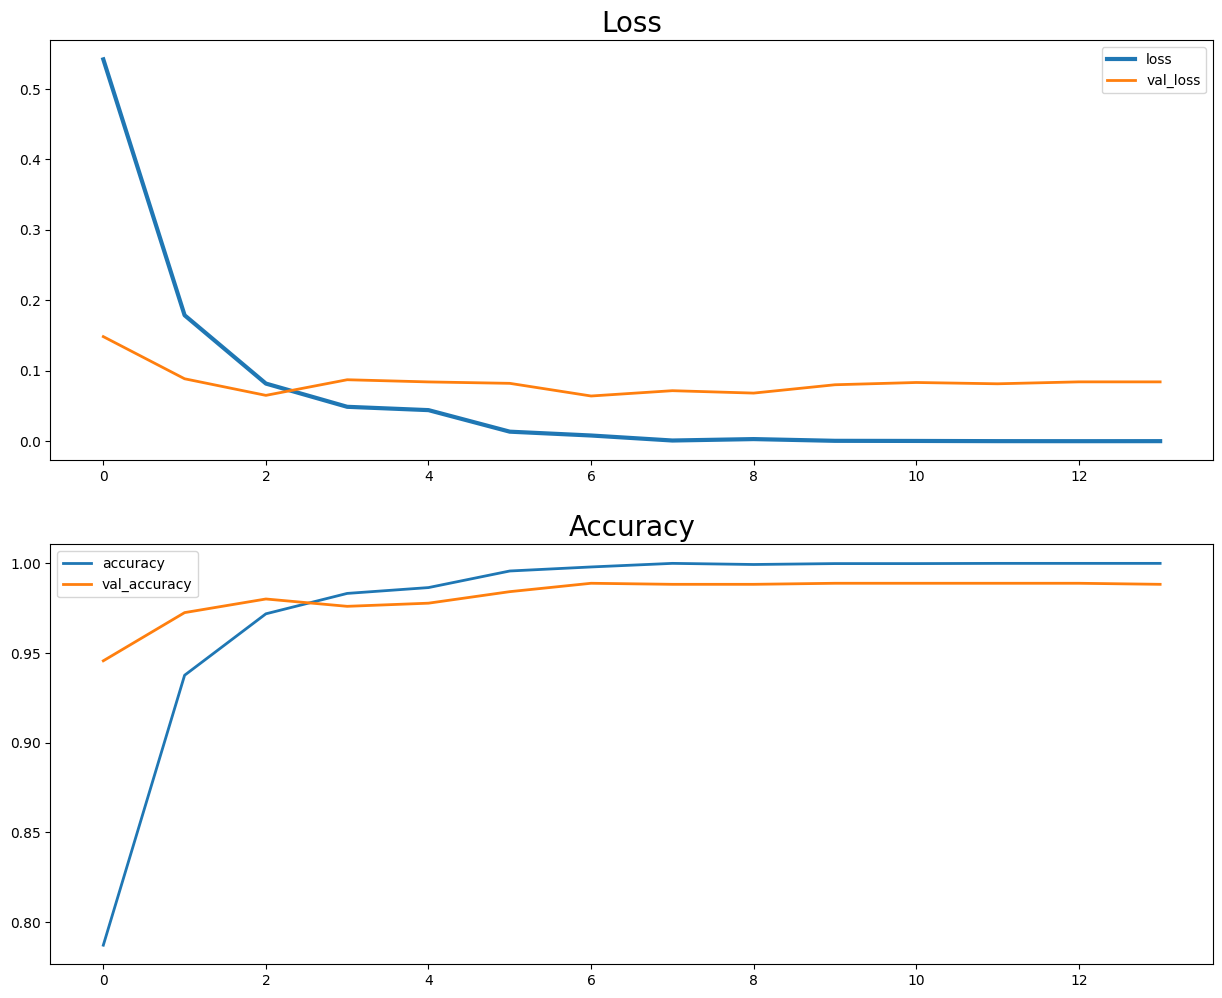

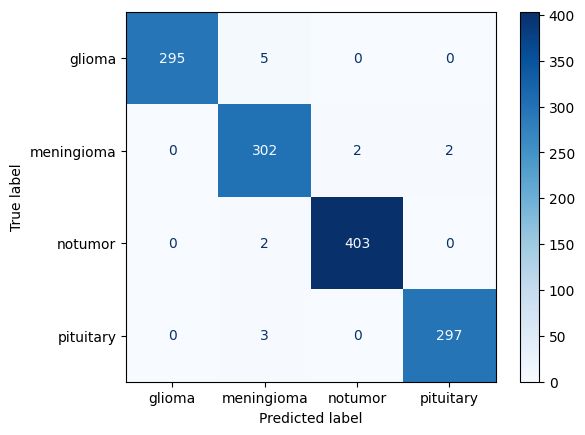

Classification Report
              precision    recall  f1-score   support

           0    1.00000   0.98333   0.99160       300
           1    0.96795   0.98693   0.97735       306
           2    0.99506   0.99506   0.99506       405
           3    0.99331   0.99000   0.99165       300

    accuracy                        0.98932      1311
   macro avg    0.98908   0.98883   0.98891      1311
weighted avg    0.98946   0.98932   0.98935      1311

Best model: EfficientnetV2B0 Augmentation Trainable First 25 Layer
Test Loss: 0.06077757105231285, Test Accuracy: 0.9893211126327515


(<keras.src.callbacks.History at 0x7f884bafabd0>,
 0.06077757105231285,
 0.9893211126327515,
 {'Model Name': ['EfficientnetV2B0 Standard Trainable First 25 Layer',
   'EfficientnetV2B3 Standard Trainable First 25 Layer',
   'EfficientnetV2M Standard Trainable Last 25 Layer',
   'EfficientnetV2B0 Augmentation Trainable Last 25 Layer',
   'EfficientnetV2B3 Augmentation Trainable Last 25 Layer',
   'EfficientnetV2B0 Augmentation Trainable First 25 Layer'],
  'Test Loss': [0.07815388590097427,
   0.067006915807724,
   0.05467250198125839,
   0.32110396027565,
   0.22040514647960663,
   0.06077757105231285],
  'Test Accuracy': [0.9855072498321533,
   0.9885583519935608,
   0.9855072498321533,
   0.8863462805747986,
   0.9282990097999573,
   0.9893211126327515],
  'Test F1Score': [0.976431,
   0.9864865,
   0.97470486,
   0.84727275,
   0.9063544,
   0.99159664],
  'Training Time': [223.0917501449585,
   381.1360716819763,
   716.5882251262665,
   76.12351202964783,
   125.09169340133667,
  

In [115]:
best_variant(model_name_1, aug_b0_tf25, history_aug_b0_tf25, training_time_1,
             model_name_2, aug_b0_tl25, history_aug_b0_tl25, training_time_2,
             model_name_3, aug_b0_nt, history_aug_b0_nt, training_time_3,
             test_ds_224, result_dict)

### EfficientNetV2B3

#### trainable first25

In [116]:
model_name_1 = 'EfficientnetV2B3 Augmentation Trainable First 25 Layer'
input_shape = (300,300,3)

aug_b3_tf25 = build_model_trainable_first25(EfficientNetV2B3, input_shape=input_shape, num_classes=4)
aug_b3_tf25, history_aug_b3_tf25, training_time_1 = train(aug_b3_tf25, model_name_1, train_aug_300, valid_aug_300, EPOCHS, SAVE_DIRECTORY)

Epoch 1/40


2024-11-04 15:30:00.631575: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_31/dropout_62/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


332/332 [==============================] - ETA: 0s - loss: 0.4334 - accuracy: 0.8341 - f1_score: 0.8302

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


332/332 [==============================] - 83s 120ms/step - loss: 0.4334 - accuracy: 0.8341 - f1_score: 0.8302 - val_loss: 0.1475 - val_accuracy: 0.9456 - val_f1_score: 0.9396 - lr: 1.0000e-04
Epoch 2/40
332/332 [==============================] - 38s 115ms/step - loss: 0.1098 - accuracy: 0.9627 - f1_score: 0.9618 - val_loss: 0.1060 - val_accuracy: 0.9682 - val_f1_score: 0.9675 - lr: 1.0000e-04
Epoch 3/40
332/332 [==============================] - 36s 109ms/step - loss: 0.0584 - accuracy: 0.9799 - f1_score: 0.9795 - val_loss: 0.0835 - val_accuracy: 0.9769 - val_f1_score: 0.9757 - lr: 1.0000e-04
Epoch 4/40
332/332 [==============================] - 36s 108ms/step - loss: 0.0328 - accuracy: 0.9897 - f1_score: 0.9895 - val_loss: 0.1189 - val_accuracy: 0.9763 - val_f1_score: 0.9749 - lr: 1.0000e-04
Epoch 5/40
332/332 [==============================] - 36s 109ms/step - loss: 0.0202 - accuracy: 0.9950 - f1_score: 0.9949 - val_loss: 0.0558 - val_accuracy: 0.9890 - val_f1_score: 0.9886 - lr: 1.

#### trainable last25

In [117]:
model_name_2 = 'EfficientnetV2B3 Augmentation Trainable Last 25 Layer'
input_shape = (300,300,3)

aug_b3_tl25 = build_model_trainable_last25(EfficientNetV2B3, input_shape=input_shape, num_classes=4)
aug_b3_tl25, history_aug_b3_tl25, training_time_2 = train(aug_b3_tl25, model_name_2, train_aug_300, valid_aug_300, EPOCHS, SAVE_DIRECTORY)

Epoch 1/40


2024-11-04 15:38:24.215614: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_32/dropout_64/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


332/332 [==============================] - 39s 67ms/step - loss: 0.4308 - accuracy: 0.8289 - f1_score: 0.8244 - val_loss: 0.1568 - val_accuracy: 0.9468 - val_f1_score: 0.9431 - lr: 1.0000e-04
Epoch 2/40
332/332 [==============================] - 21s 64ms/step - loss: 0.1314 - accuracy: 0.9553 - f1_score: 0.9539 - val_loss: 0.1750 - val_accuracy: 0.9439 - val_f1_score: 0.9426 - lr: 1.0000e-04
Epoch 3/40
332/332 [==============================] - 29s 87ms/step - loss: 0.0627 - accuracy: 0.9780 - f1_score: 0.9774 - val_loss: 0.1321 - val_accuracy: 0.9659 - val_f1_score: 0.9631 - lr: 1.0000e-04
Epoch 4/40
332/332 [==============================] - 31s 94ms/step - loss: 0.0403 - accuracy: 0.9873 - f1_score: 0.9870 - val_loss: 0.0897 - val_accuracy: 0.9745 - val_f1_score: 0.9726 - lr: 1.0000e-04
Epoch 5/40
332/332 [==============================] - 38s 113ms/step - loss: 0.0220 - accuracy: 0.9933 - f1_score: 0.9931 - val_loss: 0.0956 - val_accuracy: 0.9780 - val_f1_score: 0.9765 - lr: 1.0000

#### not trainable

In [118]:
model_name_3 = 'EfficientnetV2B3 Augmentation Not Trainable'
input_shape = (300,300,3)

aug_b3_nt = build_model_not_trainable(EfficientNetV2B3, input_shape=input_shape, num_classes=4)
aug_b3_nt, history_aug_b3_nt, training_time_3 = train(aug_b3_nt, model_name_3, train_aug_300, valid_aug_300, EPOCHS, SAVE_DIRECTORY)

Epoch 1/40
332/332 [==============================] - 23s 45ms/step - loss: 0.7894 - accuracy: 0.6765 - f1_score: 0.6632 - val_loss: 0.3788 - val_accuracy: 0.8646 - val_f1_score: 0.8553 - lr: 1.0000e-04
Epoch 2/40
332/332 [==============================] - 13s 39ms/step - loss: 0.4837 - accuracy: 0.8198 - f1_score: 0.8136 - val_loss: 0.2943 - val_accuracy: 0.8924 - val_f1_score: 0.8853 - lr: 1.0000e-04
Epoch 3/40
332/332 [==============================] - 13s 41ms/step - loss: 0.4036 - accuracy: 0.8504 - f1_score: 0.8458 - val_loss: 0.2608 - val_accuracy: 0.9034 - val_f1_score: 0.8959 - lr: 1.0000e-04
Epoch 4/40
332/332 [==============================] - 12s 37ms/step - loss: 0.3566 - accuracy: 0.8700 - f1_score: 0.8658 - val_loss: 0.2294 - val_accuracy: 0.9184 - val_f1_score: 0.9131 - lr: 1.0000e-04
Epoch 5/40
332/332 [==============================] - 12s 37ms/step - loss: 0.3304 - accuracy: 0.8778 - f1_score: 0.8740 - val_loss: 0.2119 - val_accuracy: 0.9253 - val_f1_score: 0.9197 - 

1/1 [==============================] - 0s 85ms/step


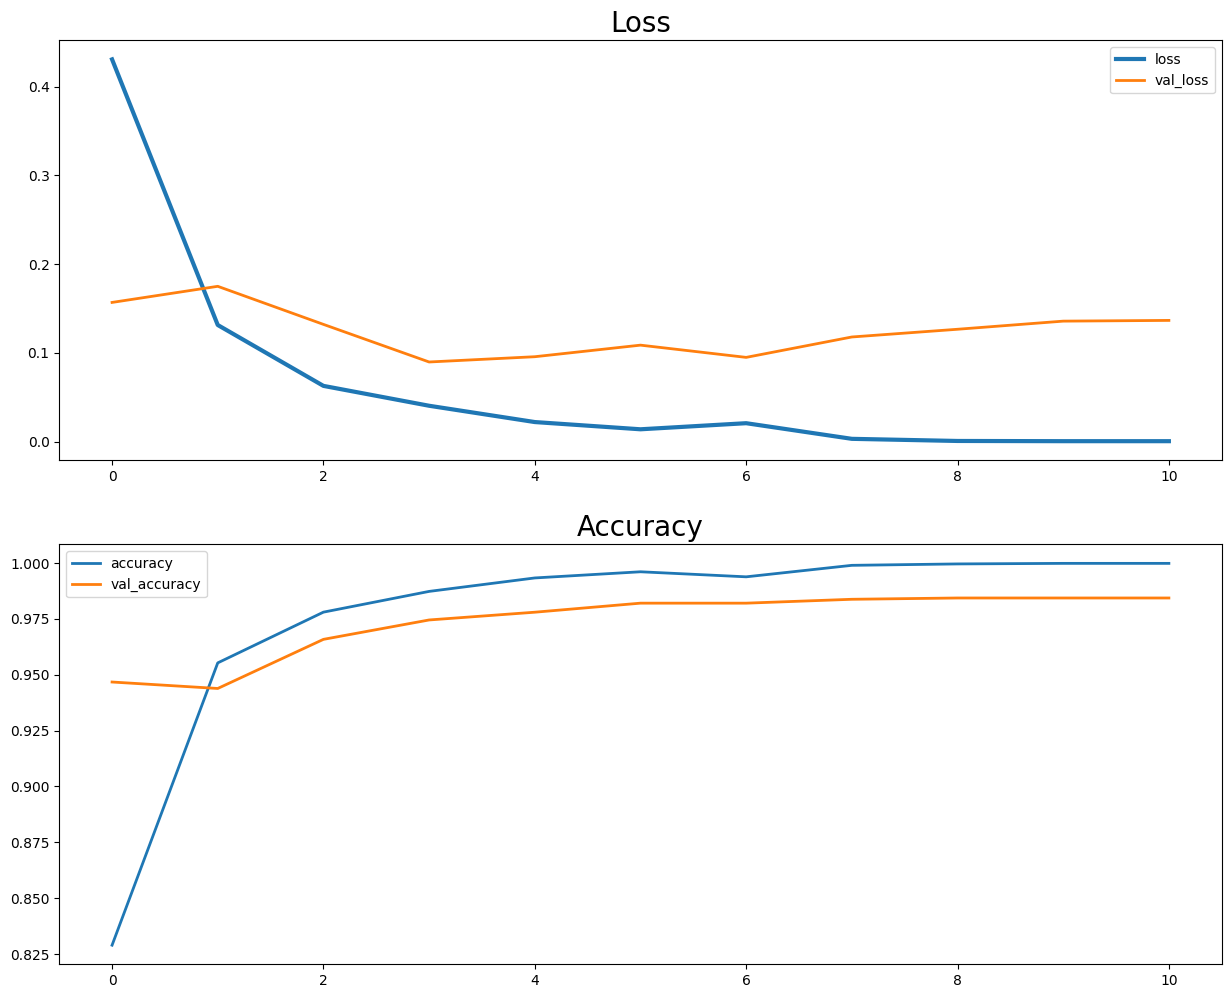

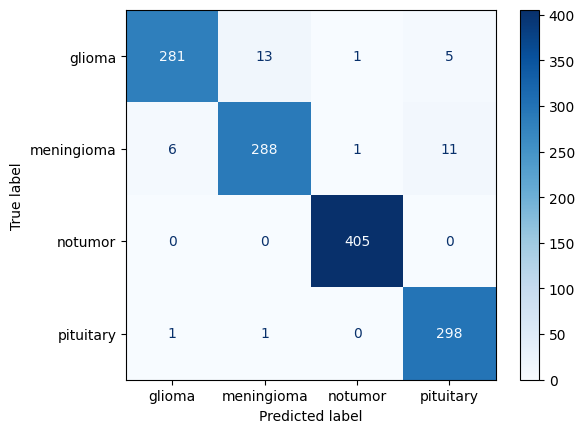

Classification Report
              precision    recall  f1-score   support

           0    0.97569   0.93667   0.95578       300
           1    0.95364   0.94118   0.94737       306
           2    0.99509   1.00000   0.99754       405
           3    0.94904   0.99333   0.97068       300

    accuracy                        0.97025      1311
   macro avg    0.96837   0.96779   0.96784      1311
weighted avg    0.97044   0.97025   0.97013      1311

Best model: EfficientnetV2B3 Augmentation Trainable Last 25 Layer
Test Loss: 0.08948302268981934, Test Accuracy: 0.970251739025116


(<keras.src.callbacks.History at 0x7f86a51f57d0>,
 0.08948302268981934,
 0.970251739025116,
 {'Model Name': ['EfficientnetV2B0 Standard Trainable First 25 Layer',
   'EfficientnetV2B3 Standard Trainable First 25 Layer',
   'EfficientnetV2M Standard Trainable Last 25 Layer',
   'EfficientnetV2B0 Augmentation Trainable Last 25 Layer',
   'EfficientnetV2B3 Augmentation Trainable Last 25 Layer',
   'EfficientnetV2B0 Augmentation Trainable First 25 Layer',
   'EfficientnetV2B3 Augmentation Trainable Last 25 Layer'],
  'Test Loss': [0.07815388590097427,
   0.067006915807724,
   0.05467250198125839,
   0.32110396027565,
   0.22040514647960663,
   0.06077757105231285,
   0.08948302268981934],
  'Test Accuracy': [0.9855072498321533,
   0.9885583519935608,
   0.9855072498321533,
   0.8863462805747986,
   0.9282990097999573,
   0.9893211126327515,
   0.970251739025116],
  'Test F1Score': [0.976431,
   0.9864865,
   0.97470486,
   0.84727275,
   0.9063544,
   0.99159664,
   0.9557823],
  'Training

In [119]:
best_variant(model_name_1, aug_b3_tf25, history_aug_b3_tf25, training_time_1,
             model_name_2, aug_b3_tl25, history_aug_b3_tl25, training_time_2,
             model_name_3, aug_b3_nt, history_aug_b3_nt, training_time_3,
             test_ds_300, result_dict)

### EfficientNetV2M

#### trainable first25

In [23]:
model_name_1 = 'EfficientnetV2M Augmentation Trainable First 25 Layer'
input_shape = (380,380,3)

aug_m_tf25 = build_model_trainable_first25(EfficientNetV2M, input_shape=input_shape, num_classes=4)
aug_m_tf25, history_aug_m_tf25, training_time_1 = train(aug_m_tf25, model_name_1, train_aug_380, valid_aug_380, EPOCHS, SAVE_DIRECTORY)

214201816/214201816 [==============================] - 5s 0us/step
Epoch 1/40


2024-11-05 01:50:03.937183: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-11-05 01:50:19.043296: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:83: Filling up shuffle buffer (this may take a while): 379 of 1000
2024-11-05 01:50:20.928443: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-11-05 01:50:21.105846: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2024-11-05 01:50:21.175786: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-11-05 01:50:23.149805: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xb6b3ff0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-05 01

998/998 [==============================] - ETA: 0s - loss: 0.5720 - accuracy: 0.7776 - f1_score: 0.7730

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


998/998 [==============================] - 252s 165ms/step - loss: 0.5720 - accuracy: 0.7776 - f1_score: 0.7730 - val_loss: 0.2438 - val_accuracy: 0.9267 - val_f1_score: 0.9243 - lr: 1.0000e-04
Epoch 2/40
998/998 [==============================] - 160s 160ms/step - loss: 0.1731 - accuracy: 0.9444 - f1_score: 0.9432 - val_loss: 0.2147 - val_accuracy: 0.9442 - val_f1_score: 0.9437 - lr: 1.0000e-04
Epoch 3/40
998/998 [==============================] - 171s 172ms/step - loss: 0.1216 - accuracy: 0.9612 - f1_score: 0.9604 - val_loss: 0.1899 - val_accuracy: 0.9326 - val_f1_score: 0.9281 - lr: 1.0000e-04
Epoch 4/40
998/998 [==============================] - 156s 156ms/step - loss: 0.0699 - accuracy: 0.9797 - f1_score: 0.9794 - val_loss: 0.1135 - val_accuracy: 0.9645 - val_f1_score: 0.9632 - lr: 1.0000e-04
Epoch 5/40
998/998 [==============================] - 154s 154ms/step - loss: 0.0706 - accuracy: 0.9791 - f1_score: 0.9787 - val_loss: 0.0840 - val_accuracy: 0.9785 - val_f1_score: 0.9777 - l

#### trainable last25

In [24]:
model_name_2 = 'EfficientnetV2M Augmentation Trainable Last 25 Layer'
input_shape = (380,380,3)

aug_m_tl25 = build_model_trainable_last25(EfficientNetV2M, input_shape=input_shape, num_classes=4)
aug_m_tl25, history_aug_m_tl25, training_time_2 = train(aug_m_tl25, model_name_2, train_aug_380, valid_aug_380, EPOCHS, SAVE_DIRECTORY)

Epoch 1/40


2024-11-05 02:42:55.869156: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


998/998 [==============================] - 125s 93ms/step - loss: 0.3933 - accuracy: 0.8536 - f1_score: 0.8499 - val_loss: 0.1491 - val_accuracy: 0.9494 - val_f1_score: 0.9463 - lr: 1.0000e-04
Epoch 2/40
998/998 [==============================] - 90s 90ms/step - loss: 0.1319 - accuracy: 0.9568 - f1_score: 0.9557 - val_loss: 0.0606 - val_accuracy: 0.9820 - val_f1_score: 0.9810 - lr: 1.0000e-04
Epoch 3/40
998/998 [==============================] - 87s 87ms/step - loss: 0.0687 - accuracy: 0.9803 - f1_score: 0.9799 - val_loss: 0.1349 - val_accuracy: 0.9645 - val_f1_score: 0.9639 - lr: 1.0000e-04
Epoch 4/40
998/998 [==============================] - 88s 89ms/step - loss: 0.0718 - accuracy: 0.9806 - f1_score: 0.9802 - val_loss: 0.2256 - val_accuracy: 0.9430 - val_f1_score: 0.9408 - lr: 1.0000e-04
Epoch 5/40
998/998 [==============================] - 88s 89ms/step - loss: 0.0479 - accuracy: 0.9867 - f1_score: 0.9866 - val_loss: 0.1476 - val_accuracy: 0.9703 - val_f1_score: 0.9688 - lr: 1.0000

#### not trainable

In [25]:
model_name_3 = 'EfficientnetV2M Augmentation Not Trainable'
input_shape = (380,380,3)

aug_m_nt = build_model_not_trainable(EfficientNetV2M, input_shape=input_shape, num_classes=4)
aug_m_nt, history_aug_m_nt, training_time_3 = train(aug_m_nt, model_name_3, train_aug_380, valid_aug_380, EPOCHS, SAVE_DIRECTORY)

Epoch 1/40
998/998 [==============================] - 70s 57ms/step - loss: 0.7672 - accuracy: 0.6811 - f1_score: 0.6703 - val_loss: 0.4239 - val_accuracy: 0.8355 - val_f1_score: 0.8244 - lr: 1.0000e-04
Epoch 2/40
998/998 [==============================] - 52s 52ms/step - loss: 0.5249 - accuracy: 0.7928 - f1_score: 0.7864 - val_loss: 0.3498 - val_accuracy: 0.8663 - val_f1_score: 0.8582 - lr: 1.0000e-04
Epoch 3/40
998/998 [==============================] - 49s 49ms/step - loss: 0.4454 - accuracy: 0.8274 - f1_score: 0.8220 - val_loss: 0.2959 - val_accuracy: 0.8872 - val_f1_score: 0.8797 - lr: 1.0000e-04
Epoch 4/40
998/998 [==============================] - 54s 54ms/step - loss: 0.4000 - accuracy: 0.8447 - f1_score: 0.8402 - val_loss: 0.2784 - val_accuracy: 0.8907 - val_f1_score: 0.8829 - lr: 1.0000e-04
Epoch 5/40
998/998 [==============================] - 57s 57ms/step - loss: 0.3610 - accuracy: 0.8591 - f1_score: 0.8551 - val_loss: 0.2596 - val_accuracy: 0.8971 - val_f1_score: 0.8900 - 

In [ ]:
best_variant(model_name_1, aug_m_tf25, history_aug_m_tf25, training_time_1,
             model_name_2, aug_m_tl25, history_aug_m_tl25, training_time_2,
             model_name_3, aug_m_nt, history_aug_m_nt, training_time_3,
             test_ds_380, result_dict)

164/164 [==============================] - 7s 42ms/step - loss: 0.0502 - accuracy: 0.9840 - f1_score: 0.9831


# Result

In [ ]:
results = pd.DataFrame(result_dict)

print(results)

In [ ]:
results.to_csv("result.csv", index=False)

df = pd.read_csv("result.csv")

print(df)

# Testing using Different Dataset

In [60]:
def evaluate_model_on_dataset(model, dataset, class_names):
    # y_true = []
    # y_pred = []

    # test_loss, test_acc, test_f1score = model.evaluate(test_ds, verbose=1)
    
    # # Iterate over the dataset
    # for images, labels in dataset:
    #     # Get true labels
    #     y_true.extend(np.argmax(labels.numpy(), axis=1))
        
    #     # Predict using the model
    #     predictions = model.predict(images)
    #     y_pred.extend(np.argmax(predictions, axis=1))
    
    # # Ensure y_true and y_pred have the same length
    # assert len(y_true) == len(y_pred), f"Length mismatch: y_true={len(y_true)}, y_pred={len(y_pred)}"
    
    # # Generate confusion matrix
    # cm = confusion_matrix(y_true, y_pred)
    
    # # Plot confusion matrix
    # plt.figure(figsize=(10, 8))
    # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    # plt.xlabel('Predicted Label')
    # plt.ylabel('True Label')
    # plt.title('Confusion Matrix')
    # plt.show()

    # # Generate classification report
    # report = classification_report(y_true, y_pred, target_names=class_names)
    # print(f"Classification Report:\n{report}")




    class_names = sorted(class_names)

    model.evaluate(dataset)

    # Make predictions
    y_pred = []
    y_true = []

    for images, labels in dataset:
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))

        # If labels are one-hot encoded, convert to class indices
        if len(labels.shape) > 1:
            labels = np.argmax(labels, axis=1)
        y_true.extend(labels)

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    
    plt.show()

    print('Classification Report')
    cr = classification_report(y_true, y_pred, digits=5)
    print(cr)
    
    return cm, cr

In [61]:
def load_new_dataset(dataset_dir, image_size=(224, 224), batch_size=32):
    dataset = tf.keras.utils.image_dataset_from_directory(
        dataset_dir,
        labels='inferred',
        label_mode='categorical',  # Assuming the dataset has multiple classes
        class_names=[class_name for class_name in os.listdir(dataset_dir)],
        seed=42,
        image_size=image_size,  # Automatically resizes images to 224x224
        batch_size=batch_size,
        shuffle=False  # Turn off shuffle for evaluation
    )
    return dataset

In [62]:
def load_best_model(model_path):
    return tf.keras.models.load_model(model_path)

Found 3057 files belonging to 4 classes.
1/1 [==============================] - 2s 2s/step


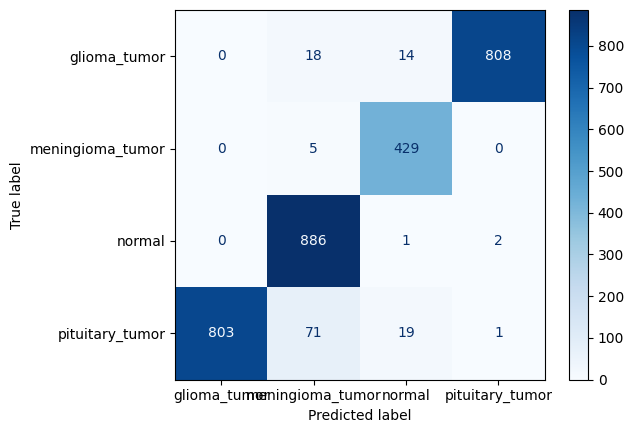

Classification Report
              precision    recall  f1-score   support

           0    0.00000   0.00000   0.00000       840
           1    0.00510   0.01152   0.00707       434
           2    0.00216   0.00112   0.00148       889
           3    0.00123   0.00112   0.00117       894

    accuracy                        0.00229      3057
   macro avg    0.00212   0.00344   0.00243      3057
weighted avg    0.00171   0.00229   0.00178      3057



(array([[  0,  18,  14, 808],
        [  0,   5, 429,   0],
        [  0, 886,   1,   2],
        [803,  71,  19,   1]]),
 '              precision    recall  f1-score   support\n\n           0    0.00000   0.00000   0.00000       840\n           1    0.00510   0.01152   0.00707       434\n           2    0.00216   0.00112   0.00148       889\n           3    0.00123   0.00112   0.00117       894\n\n    accuracy                        0.00229      3057\n   macro avg    0.00212   0.00344   0.00243      3057\nweighted avg    0.00171   0.00229   0.00178      3057\n')

In [63]:
# 1. Load the best model (replace 'path_to_best_model.h5' with the actual model file path)
best_model = load_best_model(CWD+'/model/model_efficientnetv2b0_standart_trainable_first25.h5')

# 2. Load the new dataset (replace 'path_to_new_dataset' with the actual dataset directory)
new_dataset = load_new_dataset(CWD + '/dataset/test')

class_names = new_dataset.class_names

# 4. Evaluate the model and generate confusion matrix and classification report
evaluate_model_on_dataset(best_model, new_dataset, class_names)

# Try

In [67]:
def build_model(base_model, train_ds, valid_ds, input_shape, num_classes):
    input = tf.keras.layers.Input(shape=input_shape)
    
    base_model = base_model(input_shape=input_shape, include_top=False, classes=num_classes, weights='imagenet')
    base_model.trainable = False


    x = base_model(input, training=False)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)               
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    output = tf.keras.layers.Dense(4, activation='softmax')(x)

    model = tf.keras.Model(inputs=input, outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='categorical_crossentropy',
        metrics=['accuracy', F1Score()]
    )

    # checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(saving_path, monitor='val_accuracy', save_best_only=True)

    # Early Stoping Call-Backc to stop trainig process after 'patience' epochs if the metric doesn't grow
    earlystop_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

    # ReduceLROnPlateau Call-Back to decrease learning-rate base on 'monitor' parameter after 'patience' epochs with a 'factor' is doesn't improve
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

    # Model training
    history = model.fit(
        train_ds,
        epochs=20,
        callbacks=[earlystop_cb, reduce_lr],
        validation_data=valid_ds
    )




    # Fine Tuning

    base_model.trainable = True

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy', F1Score()]
    )

    history = model.fit(
        train_ds,
        epochs=15,
        callbacks=[earlystop_cb, reduce_lr],
        validation_data=valid_ds
    )




    # Results

    # Convert result of training to DataFrame
    result = pd.DataFrame(history.history)

    # Define a X variable to store range of epochs
    x = np.arange(len(result))

    # Create a plot with 3 row and 1 col with size of (15, 12)
    fig, ax = plt.subplots(2, 1, figsize=(15, 12))

    # AX0 : Loss
    ax[0].plot(x, result.loss, label='loss', linewidth=3)
    ax[0].plot(x, result.val_loss, label='val_loss', linewidth=2, ls='-.', c='r')
    ax[0].set_title('Loss', fontsize=20)
    ax[0].set_xticks(np.arange(0, len(x), 2))
    ax[0].legend()

    #  AX1 : Loss
    ax[1].plot(x, result.accuracy, label='accuracy', linewidth=2)
    ax[1].plot(x, result.val_accuracy, label='val_accuracy', linewidth=2, ls='-.', c='r')
    ax[1].set_title('Accuracy', fontsize=20)
    ax[1].set_xticks(np.arange(0, len(x), 2))
    ax[1].legend()


    # Evaluate model
    test_loss, test_acc, test_f1score = model.evaluate(test_ds_224, verbose=1)


    # Confusion Matrix
    # Get the class names from the dataset
    class_names = sorted(classes)

    # Make predictions
    y_pred = []
    y_true = []

    for images, labels in test_ds_224:
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))

        # If labels are one-hot encoded, convert to class indices
        if len(labels.shape) > 1:
            labels = np.argmax(labels, axis=1)
        y_true.extend(labels)

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    
    plt.show()

    print('Classification Report')
    cr = classification_report(y_true, y_pred, digits=5)
    print(cr)

    return model, history, test_loss, test_acc, test_f1score

Epoch 1/20
125/125 [==============================] - 11s 41ms/step - loss: 0.5516 - accuracy: 0.7797 - f1_score: 0.7723 - val_loss: 0.3370 - val_accuracy: 0.8686 - val_f1_score: 0.8656 - lr: 0.0010
Epoch 2/20
125/125 [==============================] - 4s 30ms/step - loss: 0.3449 - accuracy: 0.8715 - f1_score: 0.8677 - val_loss: 0.2391 - val_accuracy: 0.9089 - val_f1_score: 0.9037 - lr: 0.0010
Epoch 3/20
125/125 [==============================] - 4s 30ms/step - loss: 0.2944 - accuracy: 0.8915 - f1_score: 0.8886 - val_loss: 0.2138 - val_accuracy: 0.9194 - val_f1_score: 0.9161 - lr: 0.0010
Epoch 4/20
125/125 [==============================] - 4s 29ms/step - loss: 0.2511 - accuracy: 0.9030 - f1_score: 0.8999 - val_loss: 0.2144 - val_accuracy: 0.9182 - val_f1_score: 0.9141 - lr: 0.0010
Epoch 5/20
125/125 [==============================] - 4s 30ms/step - loss: 0.2261 - accuracy: 0.9112 - f1_score: 0.9081 - val_loss: 0.2002 - val_accuracy: 0.9229 - val_f1_score: 0.9168 - lr: 0.0010
Epoch 6/2

2024-10-27 16:30:48.694599: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_27/dropout_54/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


125/125 [==============================] - 42s 81ms/step - loss: 0.0491 - accuracy: 0.9845 - f1_score: 0.9839 - val_loss: 0.1328 - val_accuracy: 0.9609 - val_f1_score: 0.9585 - lr: 1.0000e-05
Epoch 2/15
125/125 [==============================] - 10s 83ms/step - loss: 0.0438 - accuracy: 0.9855 - f1_score: 0.9851 - val_loss: 0.1226 - val_accuracy: 0.9632 - val_f1_score: 0.9611 - lr: 1.0000e-05
Epoch 3/15
125/125 [==============================] - 10s 82ms/step - loss: 0.0415 - accuracy: 0.9840 - f1_score: 0.9835 - val_loss: 0.1187 - val_accuracy: 0.9614 - val_f1_score: 0.9594 - lr: 1.0000e-05
Epoch 4/15
125/125 [==============================] - 10s 83ms/step - loss: 0.0276 - accuracy: 0.9905 - f1_score: 0.9902 - val_loss: 0.1117 - val_accuracy: 0.9679 - val_f1_score: 0.9660 - lr: 1.0000e-05
Epoch 5/15
125/125 [==============================] - 10s 82ms/step - loss: 0.0295 - accuracy: 0.9912 - f1_score: 0.9909 - val_loss: 0.1163 - val_accuracy: 0.9702 - val_f1_score: 0.9680 - lr: 1.0000e

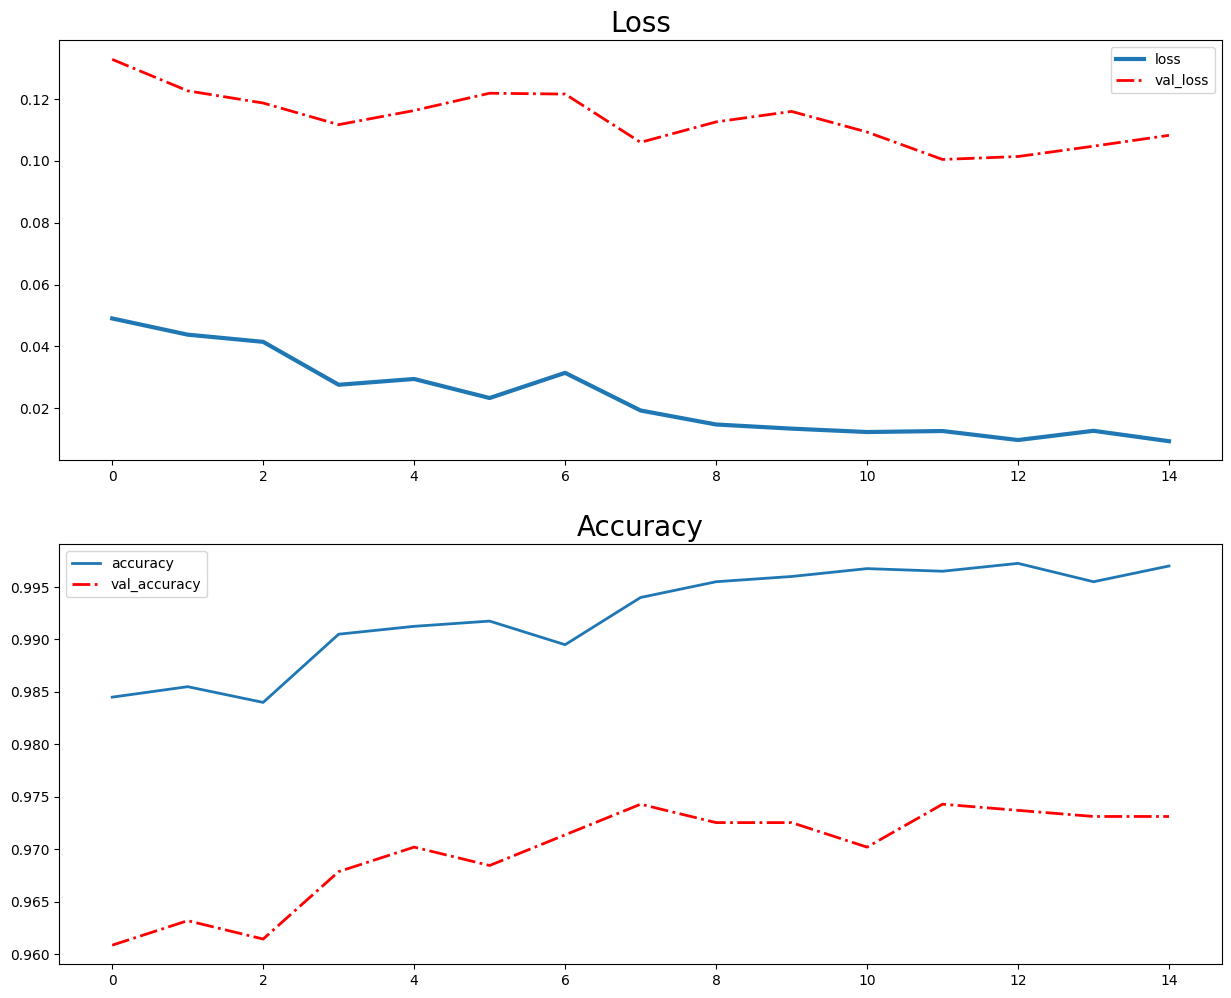

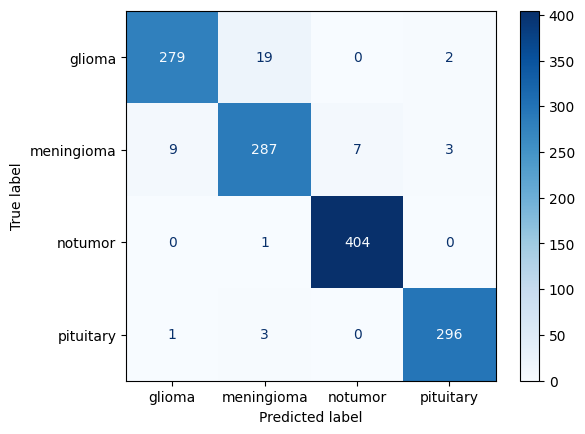

Classification Report
              precision    recall  f1-score   support

           0    0.96540   0.93000   0.94737       300
           1    0.92581   0.93791   0.93182       306
           2    0.98297   0.99753   0.99020       405
           3    0.98339   0.98667   0.98502       300

    accuracy                        0.96568      1311
   macro avg    0.96439   0.96303   0.96360      1311
weighted avg    0.96570   0.96568   0.96559      1311



In [68]:
model_name = 'test'
input_shape = (224,224,3)

model = build_model(EfficientNetV2B0, train_ds_224, valid_ds_224, input_shape=input_shape, num_classes=4)